In [1]:
import pandas as pd
import numpy as np

import os
print(os.getcwd())

/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/notebooks/DL_lpf_jitters


/Users/vega7unk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
pd.set_option('display.max_columns', None)

X, y = pd.read_pickle("/Users/vega7unk/Documents/4th Sem DSI/ilab project/ilab-group-12-1-fall-detection/data/processed/X_y_normalized_1.pkl")

In [3]:
print("X shape:", X.shape)  # Should be (samples, time_steps, features)
print("y shape:", y.shape)

X shape: (72183, 25, 6)
y shape: (72183,)


In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # Converts labels to integers

# Optionally, store label mapping
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'BSC': 0, 'CHU': 1, 'CSI': 2, 'CSO': 3, 'FKL': 4, 'FOL': 5, 'JOG': 6, 'JUM': 7, 'LYI': 8, 'SCH': 9, 'SDL': 10, 'SIT': 11, 'STD': 12, 'STN': 13, 'STU': 14, 'WAL': 15}


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.15, random_state=42)


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Attention, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Assuming X_train is your training data with shape: (num_samples, window_length, num_channels)
# Example:
#    window_length = 25 (time steps)
#    num_channels = 6 (sensor channels)
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(set(y_train))  # For instance, 16 classes if you have 16 distinct labels

# Input layer
inputs = Input(shape=input_shape)

# --- CNN Blocks ---
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)

# --- LSTM Layer ---
# return_sequences=True is important to preserve the temporal structure for the attention layer.
x = LSTM(64, return_sequences=True)(x)

# --- Self-Attention ---
# The Attention layer computes a weighted sum of the LSTM outputs.
# Using the same tensor for queries and keys/values implements self-attention.
attn_output = Attention()([x, x])
# Optionally, you can combine the attention output with the LSTM output.
# Here, we simply use the attention output further.
x = GlobalAveragePooling1D()(attn_output)

# --- Dense Layers for Classification ---
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build and compile the model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 25, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 25, 64)    │      1,216 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 25, 128)   │     24,704 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 12, 128)   │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 12, 128)   │     49,280 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 12, 64)    │     49,408 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 12, 64)    │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │      1,040 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,808 (507.06 KB)

 Trainable params: 129,808 (507.06 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.7329 - loss: 0.8814 - val_accuracy: 0.8759 - val_loss: 0.3453
Epoch 2/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8737 - loss: 0.3489 - val_accuracy: 0.8998 - val_loss: 0.2630
Epoch 3/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8949 - loss: 0.2820 - val_accuracy: 0.9129 - val_loss: 0.2191
Epoch 4/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9068 - loss: 0.2371 - val_accuracy: 0.9193 - val_loss: 0.1999
Epoch 5/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9172 - loss: 0.2070 - val_accuracy: 0.9158 - val_loss: 0.2043
Epoch 6/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9190 - loss: 0.1944 - val_accuracy: 0.9232 - val_loss: 0.1846
Epoch 7/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9271 - loss: 0.1761 - val_accuracy: 0.9256 - val_loss: 0.1775
Epoch 8/50
1918/1918 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9317 - loss: 0

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):

    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.1651
Test Accuracy: 0.9509
339/339 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


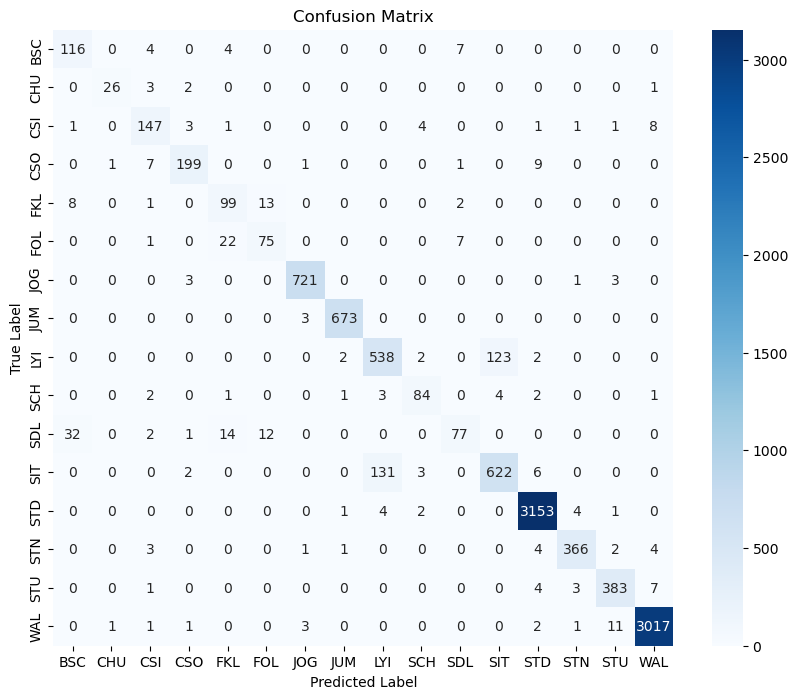

Classification Report:
               precision    recall  f1-score   support

         BSC       0.74      0.89      0.81       131
         CHU       0.93      0.81      0.87        32
         CSI       0.85      0.88      0.87       167
         CSO       0.94      0.91      0.93       218
         FKL       0.70      0.80      0.75       123
         FOL       0.75      0.71      0.73       105
         JOG       0.99      0.99      0.99       728
         JUM       0.99      1.00      0.99       676
         LYI       0.80      0.81      0.80       667
         SCH       0.88      0.86      0.87        98
         SDL       0.82      0.56      0.66       138
         SIT       0.83      0.81      0.82       764
         STD       0.99      1.00      0.99      3165
         STN       0.97      0.96      0.97       381
         STU       0.96      0.96      0.96       398
         WAL       0.99      0.99      0.99      3037

    accuracy                           0.95     10828
  

In [9]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]

metrics = evaluate_model(model, X_test, y_test, label_classes=label_classes)
